# Green AI model
### Dit model is gemaakt om te kunnen voorspellen in hoeverre de leefbaarheid, en het milieugezondheidsrisico van een postcode in Nederland verbeterd kan worden door het aanleggen van meer groen in de buurt.

 - Abel van Dijk

### Importeren van de data en libraries, en data analyseren

In [144]:
import pandas as pd
from functools import reduce
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
import joblib
from sklearn.metrics import r2_score, mean_squared_error


In [145]:
# importeer de csv bestanden
Groenkaart = pd.read_csv('ai-data/Groenkaart.csv', sep=';')
Leefbaarometer = pd.read_csv('ai-data/Leefbaarometer.csv', sep=',')
Milieugezondheidrisico = pd.read_csv('ai-data/MilieuGezondheidRisico.csv', sep=',')
TreesBushesGrass = pd.read_csv('ai-data/TreesBushesGrass.csv', sep=',')
data = []
data.append(Groenkaart)
# data.append(Leefbaarometer)
data.append(Milieugezondheidrisico)
data.append(TreesBushesGrass)

In [146]:
for dataframe in data:
    print(dataframe.head())

   fid  postcode groen_mean  groen_median groen_stdev  groen_min groen_max,,
0    1      1011          4             4           0          4         4,,
1    2      1012          4             4           0          4         4,,
2    3      1013          4             4           0          4         4,,
3    4      1014          4             4           0          4         4,,
4    5      1015          4             4           0          4         4,,
   fid  postcode  aantal_inwoners  percentage_laag_inkomen_huishouden  \
0    1      1011             9910                              -99995   
1    2      1012             8900                              -99995   
2    3      1013            22350                              -99995   
3    4      1014             3900                              -99995   
4    5      1015            14850                              -99995   

   omgevingsadressendichtheid  stedelijkheid  mgr_mean  mgr_median  mgr_stdev  \
0                 

Alle dataframes bevatten een kolom met de postcode in pc4 format, (4 cijfers) en een kolom met de waarde van de variabele. De postcode in pc4 format is een unieke identifier voor elke postcode in Nederland. Dit betekent dat we de dataframes kunnen samenvoegen op basis van deze kolom.

### Samenvoegen van de dataframes


In [147]:
for i, df in enumerate(data):
    for col in df.columns:
        if col.lower() in ['postcode', 'pc4']:
            df.rename(columns={col: 'pc4'}, inplace=True)
    data[i] = df

merged_df = reduce(lambda left, right: pd.merge(left, right, on='pc4', how='outer'), data)

print(merged_df.head())

print(merged_df.columns)

   fid_x   pc4 groen_mean  groen_median groen_stdev  groen_min groen_max,,  \
0      1  1011          4             4           0          4         4,,   
1      2  1012          4             4           0          4         4,,   
2      3  1013          4             4           0          4         4,,   
3      4  1014          4             4           0          4         4,,   
4      5  1015          4             4           0          4         4,,   

   fid_y  aantal_inwoners  percentage_laag_inkomen_huishouden  ...  \
0      1             9910                              -99995  ...   
1      2             8900                              -99995  ...   
2      3            22350                              -99995  ...   
3      4             3900                              -99995  ...   
4      5            14850                              -99995  ...   

   stedelijkheid  mgr_mean  mgr_median  mgr_stdev   mgr_min    mgr_max  \
0              1  7.290559    7.1334

### Missende data

In [148]:
missing_data = merged_df.isnull().sum()
missing_data_percentage = (missing_data / len(merged_df)) * 100
missing_data_percentage = missing_data_percentage[missing_data_percentage > 0]
print(missing_data_percentage)

Series([], dtype: float64)


### Verwijderen van onnodige kolommen
- fid_x en fid_y slechts een id, kan verwijderd worden
Leefbaarheid wordt gevormd door
- Woningvoorraad
- Fysieke omgeving
- Voorzieningen
- Sociale samenhang
- Overlast en onveiligheid
Deze subvariabelen zijn in de meeste rijen niet ingevuld, en zijn dus niet handig om te gebruiken. We verwijderen ze.

- jaar_van en jaar_naar zijn niet nodig omdat de AI geen tijdsafhankelijk is.

-lbm (Leefbaarometer) is een waarde die we willen voorspellen, en is dus de target variable. Deze kolom willen we behouden, daarom verwijder ik de rijen met een null waarde in deze kolom.

In [149]:
# Verwijder de kolommen die niet nodig zijn
merged_df.drop(columns=['fid_x', 'fid_y',
                        #'fys', 'onv', 'soc', 'vrz', 'won', 'jaar_naar', 'jaar_van'
                        ], inplace=True)

# Verwijder de rijen met een null waarde in de kolom 'lbm'
# merged_df.dropna(subset=['lbm'], inplace=True)

merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4070 entries, 0 to 4069
Data columns (total 19 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   pc4                                 4070 non-null   int64  
 1   groen_mean                          4070 non-null   object 
 2   groen_median                        4070 non-null   int64  
 3   groen_stdev                         4070 non-null   object 
 4   groen_min                           4070 non-null   int64  
 5   groen_max,,                         4070 non-null   object 
 6   aantal_inwoners                     4070 non-null   int64  
 7   percentage_laag_inkomen_huishouden  4070 non-null   int64  
 8   omgevingsadressendichtheid          4070 non-null   int64  
 9   stedelijkheid                       4070 non-null   int64  
 10  mgr_mean                            4070 non-null   float64
 11  mgr_median                          4070 no

### Niet-numerieke kolommen
de kolommen groen_mean, groen_stdev, groen_max bevatten bevatten objects in plaats van floats. bij het bekijken van de data zie ik dat er een fout lijkt te zijn, omdat de waarden van 1 tot 4 horen te zijn, maar enorme waarden bevatten. Dit komt omdat de kaart -9999 bevat op locaties waar geen groen is. de waarden 1 tot 4 zijn categorisch. Bij het berekenen van het gemiddelde, standaard deviatie en maximum, worden dus vreemde getallen berekend. Ik denk dat dit komt omdat Qgis niet goed kan rekenen met de -9999 waarde. Omdat de meeste rijen nu hele rare data bevatten, verwijder ik deze kolommen.

Omdat het categorische data betreft, lijkt de Median

In [150]:
# delete the columns groen_mean;groen_median;groen_stdev;groen_min;groen_max,

merged_df.drop(columns=['groen_mean', 'groen_median', 'groen_stdev', 'groen_min', 'groen_max,,'], inplace=True)

merged_df.describe()

,pc4,aantal_inwoners,percentage_laag_inkomen_huishouden,omgevingsadressendichtheid,stedelijkheid,mgr_mean,mgr_median,mgr_stdev,mgr_min,mgr_max,mgr_range,PercentageTrees,PercentageBushes,PercentageGrass
count,4070.000000,4070.000000,4070.0,4070.000000,4070.000000,4070.000000,4070.000000,4070.000000,4070.000000,4070.000000,4070.000000,4070.000000,4070.000000,4070.000000
mean,5669.139803,3982.610074,-99995.0,1050.003194,-20.828256,4.122685,3.944855,0.626274,3.075945,8.073461,4.997517,32.588693,8.692052,47.587354
std,2670.014850,7856.638075,0.0,2127.913780,1567.495152,1.073944,1.012014,0.328677,1.342991,2.473644,2.326455,11.483787,1.594413,10.970378
min,1011.000000,-99997.000000,-99995.0,-99997.000000,-99997.000000,2.019631,2.552323,0.047456,0.000000,3.111541,0.339382,0.000000,1.990000,13.890000
25%,3329.500000,725.000000,-99995.0,124.000000,2.000000,3.313683,3.196496,0.386605,2.743936,6.400044,3.404310,24.392500,7.770000,39.560000
50%,5697.500000,2797.500000,-99995.0,526.000000,4.000000,3.872290,3.683171,0.577386,3.224374,7.759539,4.639960,29.550000,8.460000,47.335000
75%,8042.750000,7140.000000,-99995.0,1563.500000,5.000000,4.733281,4.500638,0.803512,3.797475,9.335567,6.147952,39.997500,9.290000,55.890000
max,9999.000000,28185.000000,-99995.0,11760.000000,5.000000,13.014039,12.994216,3.122285,7.863830,27.410721,21.155798,70.450000,23.060000,91.490000


### relaties vinden tussen de variabelen
Het kan zijn dat er simpele correlaties zijn tussen de variabelen. Dit kan helpen om te begrijpen hoe de data in elkaar steekt, en kan ook helpen om de AI beter te maken. We gaan kijken naar de correlatie tussen de variabelen.

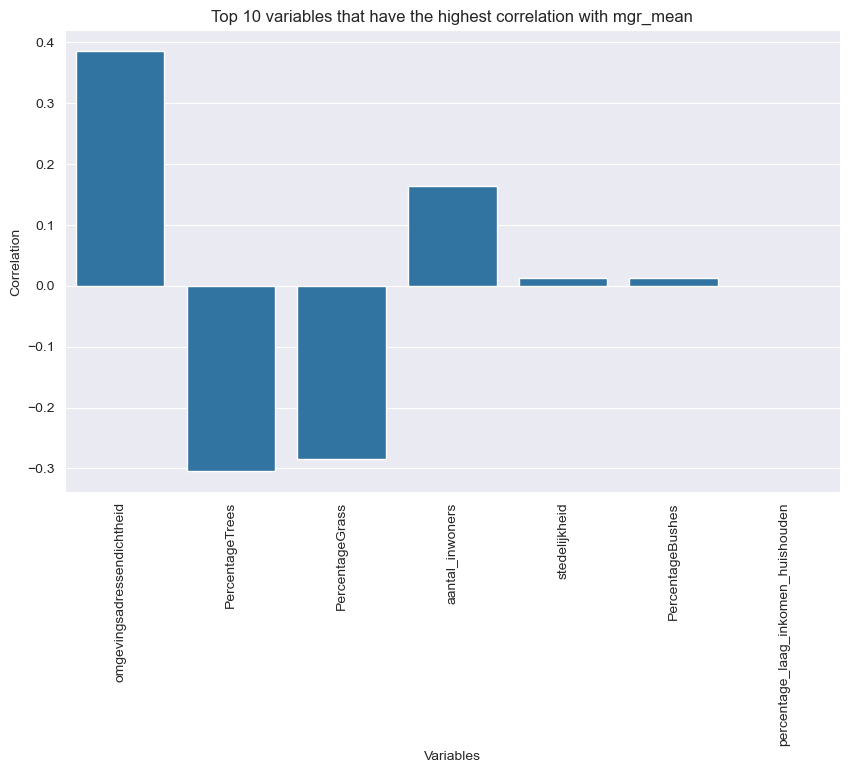

In [151]:
# # print the top 10 of variables that have the highest correlation with lbm
# correlation = merged_df.corr()
# correlation = correlation['lbm']
# correlation = correlation.reindex(correlation.abs().sort_values(ascending=False).index)
# correlation = correlation[1:11]
# plt.figure(figsize=(10, 6))
# sns.barplot(x=correlation.index, y=correlation.values)
# plt.xticks(rotation=90)
# plt.title('Top 10 variables that have the highest correlation with lbm')
# plt.xlabel('Variables')
# plt.ylabel('Correlation')
# plt.show()

# print the top 10 of variables that have the highest correlation with mgr_mean
exclude = ['mgr_median', 'mgr_stdev', 'mgr_min', 'mgr_max', 'mgr_range', 'pc4']
temp_df = merged_df.drop(columns=exclude)
correlation = temp_df.corr()
correlation = correlation['mgr_mean']
correlation = correlation.reindex(correlation.abs().sort_values(ascending=False).index)
correlation = correlation[1:11]
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation.index, y=correlation.values)
plt.xticks(rotation=90)
plt.title('Top 10 variables that have the highest correlation with mgr_mean')
plt.xlabel('Variables')
plt.ylabel('Correlation')
plt.show()

We zien hier dat de variabelen: omgevingsadressendichtheid, en stedelijkheid de hoogste correlatie hebben met de leefbaarometer. Echter zijn deze scores niet hoog. Ongeveer 0.15.

Het Milieugezondheidsrisico lijkt betere correlaties te hebben. De Stedelijkheid en omgevingsgeadressendichtheid hebben een correlatie van ongeveer 0.6.

Deze correlaties zijn echter niet erg nuttig voor het model, we willen namelijk zien wat de impact is van kleine veranderingen die gewone burgers kunnen uitvoeren, zoals het planten van struiken en gras. Daarom gaan we de data verder analyseren met minder kolommen.


In [152]:
print(merged_df.columns)
drop_columns = ['aantal_inwoners', 'percentage_laag_inkomen_huishouden', 'omgevingsadressendichtheid', 'mgr_median', 'mgr_stdev', 'mgr_min', 'mgr_max', 'mgr_range']
merged_df = merged_df.drop(columns=drop_columns)

# create a svm model to predict the lbm (leefbaarometer) and mgr_mean based on the other variable

X = merged_df.drop(columns=[
    # 'lbm',
    'mgr_mean', 'pc4'])
# y_lbm = merged_df['lbm']
y_mgr = merged_df['mgr_mean']
# X_train, X_test, y_train_lbm, y_test_lbm = train_test_split(X, y_lbm, test_size=0.2, random_state=42)
X_train_mgr, X_test_mgr, y_train_mgr, y_test_mgr = train_test_split(X, y_mgr, test_size=0.2, random_state=42)
#
# model = svm.SVR(kernel='linear')
# model.fit(X_train, y_train_lbm)
# y_pred_lbm = model.predict(X_test)
model_mgr = svm.SVR(kernel='linear')
model_mgr.fit(X_train_mgr, y_train_mgr)
y_pred_mgr = model_mgr.predict(X_test_mgr)

# show results

merged_df.to_csv('merged_df.csv', index=False)

Index(['pc4', 'aantal_inwoners', 'percentage_laag_inkomen_huishouden',
       'omgevingsadressendichtheid', 'stedelijkheid', 'mgr_mean', 'mgr_median',
       'mgr_stdev', 'mgr_min', 'mgr_max', 'mgr_range', 'PercentageTrees',
       'PercentageBushes', 'PercentageGrass'],
      dtype='object')


In [153]:
# joblib.dump(model, 'svm_lbm_model.joblib')
joblib.dump(model_mgr, 'svm_mgr_model.joblib')

['svm_mgr_model.joblib']

In [154]:
# Load the models
# model_lbm = joblib.load('svm_lbm_model.joblib')
model_mgr = joblib.load('svm_mgr_model.joblib')

print(type(model_mgr))
print(model_mgr.get_params())
print(X_train_mgr.columns)

# Predict using the models
# y_pred_lbm = model_lbm.predict(X_test)
y_pred_mgr = model_mgr.predict(X_test_mgr)

<class 'sklearn.svm._classes.SVR'>
{'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Index(['stedelijkheid', 'PercentageTrees', 'PercentageBushes',
       'PercentageGrass'],
      dtype='object')


In [155]:
# Test lbm model
# r2_lbm = r2_score(y_test_lbm, y_pred_lbm)
# mse_lbm = mean_squared_error(y_test_lbm, y_pred_lbm)
# print(f'lbm model - R²: {r2_lbm:.3f}, MSE: {mse_lbm:.3f}')

# Test mgr_mean model
r2_mgr = r2_score(y_test_mgr, y_pred_mgr)
mse_mgr = mean_squared_error(y_test_mgr, y_pred_mgr)
print(f'mgr_mean model - R²: {r2_mgr:.3f}, MSE: {mse_mgr:.3f}')

mgr_mean model - R²: 0.239, MSE: 0.897


Deze resultaten laten zien dat het model om de leefbaarometer te voorspellen erg slecht is. Hij heeft namelijk een R² score van 0.015, terwijl doorgaans een score vanaf 0.5 pas significant is. Het model voor het voorspellen van het Milieugezondheidsrisico is beter, met een R² score van 0.386, de foutmarge is wel groter, met een MSE van 0.677.

